# Final Project
Quinn Frank <br>
November 23, 2020

In [1]:
# Import NLTK to load training data
import nltk
nltk.download("tagsets")
nltk.download("brown")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
# Potentially: http://www.anc.org/software/anc-tool/

# Import my modules
from hmm import HMM
from blstm import *
from tagging_results import TaggingResults

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# CAN LOAD PRE-TRAINED MODELS HERE

def enpickle(obj, file):
    import pickle
    with open(file, 'wb') as out_file:
        pickle.dump(obj, out_file)

def unpickle(file):
    import pickle
    with open(file, 'rb') as in_file:
        pickle_dict = pickle.load(in_file, encoding='bytes')
    return pickle_dict

#hmm = unpickle("models/hmm")
#summ = unpickle("models/blstm_train_summ")
#net = torch.load("models/blstm")

## Step 2: Generative Model

In [3]:
train_size, test_size = 10000, 2000   # actual test set may be < test_size
train = nltk.corpus.brown.tagged_sents(tagset="universal")[:train_size]
test = nltk.corpus.brown.tagged_sents(tagset="universal")[train_size:train_size+test_size]

In [4]:
hmm = HMM()
%time hmm.fit(train)
%time test_sents, y_true, y_predict = hmm.split_predict(test)    # time this

Wall time: 1min 35s
Wall time: 3.76 s


In [5]:
# Calculate accuracy of HMM on both datasets
hmm_train = TaggingResults(hmm, train, hmm.vocab, hmm.tagset)
hmm_test = TaggingResults(hmm, test, hmm.vocab, hmm.tagset)

hmm_train.get_accuracy()
hmm_test.get_accuracy()


Accuracy
--------
total               0.9769
in vocab            0.9769
out of vocab           NaN
ambiguous tokens    0.9254
dtype: float64

Accuracy
--------
total               0.9188
in vocab            0.9647
out of vocab        0.2622
ambiguous tokens    0.8671
dtype: float64


## Step 3: Discriminative Model

In [6]:
untagged_train = nltk.corpus.brown.sents()[:train_size]
%time embedder = train_fasttext(untagged_train)

# Also store the vocabulary for later
net_vocab = pd.Index(sorted(set(sum(untagged_train, []))))

Wall time: 9.33 s


In [7]:
train_set = POSDataset(train, embedder, hmm.tagset)
test_set = POSDataset(test, embedder, hmm.tagset)

# Network is loaded onto a GPU by default
# (to run on cpu, remove .cuda() and set use_cuda below to False)
net = BLSTM(100, len(hmm.tagset), 128, 2, 0.2)

In [11]:
net.cuda()
%time summ = train_BLSTM(net, train_set, test_set, \
                         num_epochs=40, batch_size=16, use_cuda=True, \
                         print_every=5, train_summ=summ, \
                         opt_params={'lr': 0.1, 'momentum': 0.9})

- EPOCH 5:
  train loss = 0.5759339928627014
  accuracy   = 0.9202 (train) / 0.8831 (test)
----------------------------
- EPOCH 10:
  train loss = 0.5776965618133545
  accuracy   = 0.9253 (train) / 0.8835 (test)
----------------------------
- EPOCH 15:
  train loss = 0.5136995911598206
  accuracy   = 0.9324 (train) / 0.8835 (test)
----------------------------
- EPOCH 20:
  train loss = 0.561957836151123
  accuracy   = 0.9371 (train) / 0.883 (test)
----------------------------
- EPOCH 25:
  train loss = 0.5960726737976074
  accuracy   = 0.9383 (train) / 0.8795 (test)
----------------------------
- EPOCH 30:
  train loss = 0.5420691967010498
  accuracy   = 0.9445 (train) / 0.8779 (test)
----------------------------
- EPOCH 35:
  train loss = 0.5644589066505432
  accuracy   = 0.9472 (train) / 0.8785 (test)
----------------------------
- EPOCH 40:
  train loss = 0.5258644223213196
  accuracy   = 0.9503 (train) / 0.8773 (test)
----------------------------
Wall time: 7min 22s


Wall time: 1.76 s


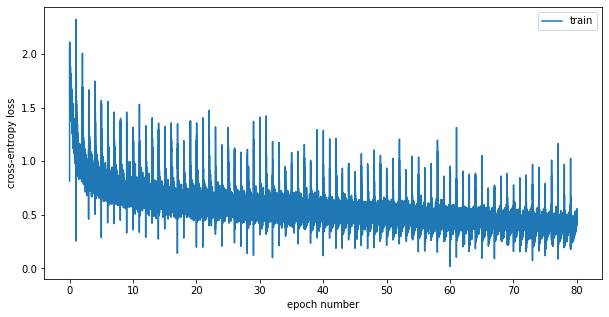

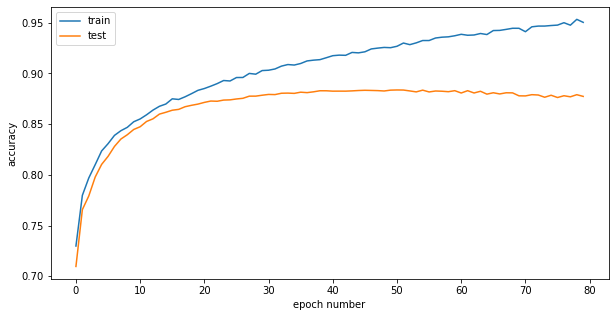


Accuracy
--------
total               0.9417
in vocab            0.9417
out of vocab           NaN
ambiguous tokens    0.9424
dtype: float64

Accuracy
--------
total               0.8728
in vocab            0.8850
out of vocab        0.7269
ambiguous tokens    0.8272
dtype: float64


In [12]:
net.cpu()
%time test_sents, y_true, y_predict = net.split_predict(test_set)   # time this
plot_train_summ(summ)

# Calculate accuracy of BiLSTM on both datasets
net_train = TaggingResults(net, train, net_vocab, hmm.tagset, embedder)
net_test = TaggingResults(net, test, net_vocab, hmm.tagset, embedder)

net_train.get_accuracy()
net_test.get_accuracy()

In [21]:
# STORE MODELS HERE ONCE TRAINED

def enpickle(obj, file):
    import pickle
    with open(file, 'wb') as out_file:
        pickle.dump(obj, out_file)

def unpickle(file):
    import pickle
    with open(file, 'rb') as in_file:
        pickle_dict = pickle.load(in_file, encoding='bytes')
    return pickle_dict

enpickle(hmm, "models/hmm")
enpickle(summ, "models/blstm_train_summ")
torch.save(net, "models/blstm")

# Step 4: Application to Artificial Data

In [13]:
# Generate an artificial tagged dataset to test on
%time artificial = hmm.generate(1000)

Wall time: 11.8 s


In [14]:
# Calculate the accuracy on the artifical dataset
hmm_art = TaggingResults(hmm, artificial, hmm.vocab, hmm.tagset)
net_art = TaggingResults(net, artificial, net_vocab, hmm.tagset, embedder)

hmm_art.get_accuracy()
net_art.get_accuracy()


Accuracy
--------
total               0.9793
in vocab            0.9793
out of vocab           NaN
ambiguous tokens    0.9038
dtype: float64

Accuracy
--------
total               0.7824
in vocab            0.7891
out of vocab        0.7013
ambiguous tokens    0.7206
dtype: float64


In [20]:
net_art.get_sent(5)

           true predict correct? oov? ambiguous?
token                                           
means      NOUN    NOUN        ✓               *
keyed      VERB    VERB        ✓                
be         VERB    VERB        ✓                
much        ADJ     ADV                        *
moore      NOUN     ADV             *           
as          ADP     ADP        ✓               *
witty       ADJ    NOUN                         
on          ADP     ADP        ✓               *
direction  NOUN    NOUN        ✓                
except      ADP    NOUN                         
army       NOUN    NOUN        ✓                
is         VERB    VERB        ✓                
family     NOUN    VERB                         
``            .       .        ✓                
the         DET     DET        ✓                
acres      NOUN    NOUN        ✓                
also        ADV     ADV        ✓                
is         VERB    VERB        ✓                
had        VERB    V

# Step 5: Application to Real Data

### Moby-Dick

In [22]:
from nltk.tag import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize

In [23]:
# Let NLTK annotate (tokenize and tag)
moby_words = nltk.corpus.gutenberg.words("melville-moby_dick.txt")
moby = list(map(lambda sent: pos_tag(word_tokenize(sent), tagset='universal'),
                sent_tokenize(' '.join(moby_words))))

In [24]:
# Calculate the accuracy on Moby-Dick
hmm_moby = TaggingResults(hmm, moby, hmm.vocab, hmm.tagset)
net_moby = TaggingResults(net, moby, net_vocab, hmm.tagset, embedder)

hmm_moby.get_accuracy()
net_moby.get_accuracy()


Accuracy
--------
total               0.8038
in vocab            0.8743
out of vocab        0.2800
ambiguous tokens    0.7766
dtype: float64

Accuracy
--------
total               0.7927
in vocab            0.8160
out of vocab        0.6475
ambiguous tokens    0.6117
dtype: float64


In [30]:
net_moby.get_sent(10000)

           true predict correct? oov? ambiguous?
token                                           
So          ADV     ADV        ✓               *
,             .       .        ✓                
floating   VERB    VERB        ✓               *
on          ADP     ADP        ✓                
the         DET     DET        ✓                
margin     NOUN    NOUN        ✓                
of          ADP     ADP        ✓                
the         DET     DET        ✓                
ensuing    VERB    VERB        ✓               *
scene      NOUN    NOUN        ✓                
,             .       .        ✓                
and        CONJ    CONJ        ✓                
in          ADP     ADP        ✓                
full        ADJ     ADJ        ✓                
sight      NOUN    NOUN        ✓               *
of          ADP     ADP        ✓                
it         PRON    PRON        ✓                
,             .       .        ✓                
when        ADV     

### Trump Tweets

In [897]:
import re

hyperlink = r"http\S*\s"
trump_words = ' ! '.join(pd.read_json("trump.json", encoding="utf8").text)
trump_words = re.sub(hyperlink, "", trump_words)

trump = list(map(lambda sent: pos_tag(word_tokenize(sent), tagset='universal'),
                 sent_tokenize(trump_words)))

In [901]:
trump_set = POSDataset(trump, embedder, hmm.tagset)
model.cpu()
g_true, g_predict = hmm.split_predict(trump)
d_true, d_predict = model.split_predict(trump_set)

In [904]:
idx = 300
print(trump[idx])
print(g_true[idx])
print(g_predict[idx])
print(d_true[idx])
print(d_predict[idx])

[('Tractors', 'NOUN'), ('blocked', 'VERB'), ('doors', 'NOUN'), ('&', 'CONJ'), ('amp', 'NOUN'), (';', '.'), ('windows', 'NOUN'), ('were', 'VERB'), ('covered', 'VERB'), ('with', 'ADP'), ('thick', 'ADJ'), ('cardboard', 'NOUN'), ('so', 'ADP'), ('that', 'DET'), ('observers', 'NOUN'), ('could', 'VERB'), ('not', 'ADV'), ('see', 'VERB'), ('into', 'ADP'), ('the', 'DET'), ('count', 'NOUN'), ('rooms', 'NOUN'), ('.', '.')]
[6, 10, 6, 4, 6, 0, 6, 10, 10, 2, 1, 6, 2, 5, 6, 10, 3, 10, 2, 5, 6, 6, 0]
[8, 10, 6, 4, 7, 0, 6, 10, 10, 2, 1, 4, 3, 2, 6, 10, 3, 10, 2, 5, 6, 6, 0]
[6, 10, 6, 4, 6, 0, 6, 10, 10, 2, 1, 6, 2, 5, 6, 10, 3, 10, 2, 5, 6, 6, 0]
[6, 10, 6, 6, 6, 0, 6, 10, 10, 2, 1, 6, 2, 2, 6, 10, 3, 10, 2, 5, 6, 6, 0]
